# Classification. Linear models and KNN

In [1]:
from tabulate import tabulate

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [4]:
PATH = "./data/"

In [5]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [6]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [7]:
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
data[data.Survived==1].Sex.value_counts()

female    233
male      109
Name: Sex, dtype: int64

In [9]:
female_surv = 233; female_died = 81
male_surv = 109;   male_died = 468

In [10]:
print('survivors for every death', f'females: {female_surv/female_died}', f'males: {male_surv/male_died}',sep='\n')

survivors for every death
females: 2.876543209876543
males: 0.2329059829059829


So there defenetely was a huge lack of lifeboats and being female makes you about 12 times more likely to survive.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

          Overall    Survived     Died
------  ---------  ----------  -------
mean      29.6991     28.3437  30.6262
median    28          28       28


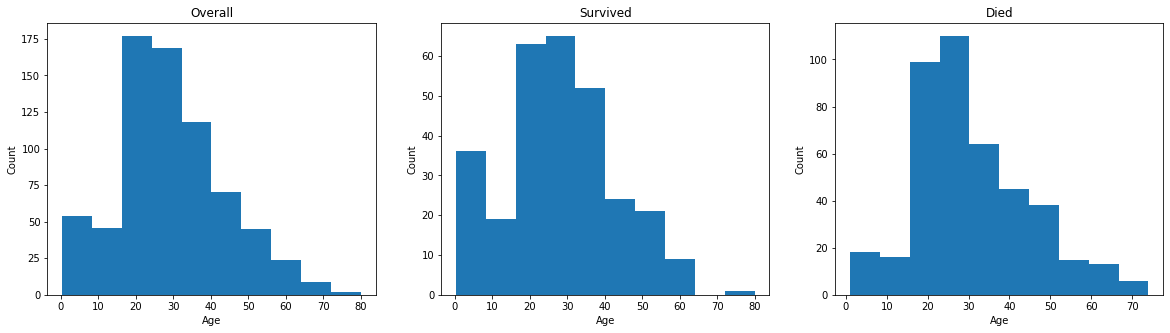

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,5))
ages = {'Overall': data.Age, 'Survived': data[data.Survived == 1].Age, 'Died': data[data.Survived == 0].Age}
axes = (ax1, ax2, ax3)

for ax, age in zip(axes, ages.values()):
    ax.hist(age)

for ax, title in zip(axes, ages.keys()):
    ax.set_xlabel('Age')
    ax.set_ylabel('Count')
    ax.set_title(title)

print(tabulate([[age.mean() for age in ages.values()],
                [age.median() for age in ages.values()]],
               ['Overall', 'Survived', 'Died'], showindex=['mean', 'median']))

The only significant difference in age distribution for survived passengers is in ages under 10, which is not surprising. Almost equal mean and median values imply a symmetrical distribution with very small skew.

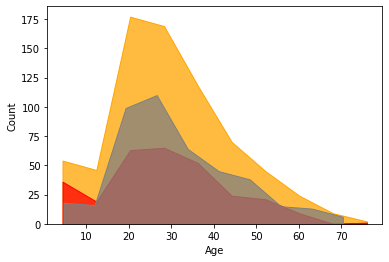

In [12]:
for age, color in zip(ages.values(), ('orange', 'red', 'grey')):
    sns.histplot(age, color=color, bins=10, element='poly')


**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [13]:
print(data.Pclass.unique(), data.Embarked.unique())
#let's see what values these features consist of

[3 1 2] ['S' 'C' 'Q' nan]


In [14]:
#now find survival rate for every class and plot it
class_count = data.groupby(by='Pclass').Name.count()
class_count

Pclass
1    216
2    184
3    491
Name: Name, dtype: int64

In [15]:
class_surv = data.groupby(by='Pclass').Survived.value_counts()
class_surv

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [16]:
First =  class_surv[1,1]/class_count[1]
Second = class_surv[2,1]/class_count[2]
Third =  class_surv[3,1]/class_count[3]

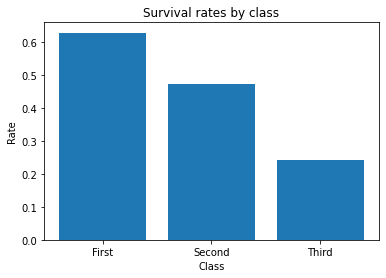

In [17]:
plt.bar(('First', 'Second', 'Third'), (First, Second, Third))
plt.xlabel('Class')
plt.ylabel('Rate')
plt.title('Survival rates by class');

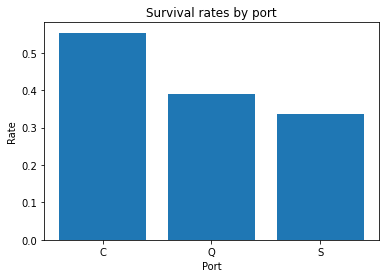

In [18]:
#repeat it for embarkation port
dropped = data.dropna(subset=['Embarked'])
embark_count = dropped.groupby('Embarked').Name.count()
embark_surv = dropped.groupby('Embarked').Survived.value_counts()

C, Q, S = [embark_surv[port,1]/embark_count[port] for port in ('C','Q','S')]

plt.bar(('C', 'Q', 'S'), (C, Q, S))
plt.xlabel('Port')
plt.ylabel('Rate')
plt.title('Survival rates by port');

It's clearly seen that passangers with higher ticket class and C port embarkation are more survivable.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [19]:
data.isna().mean().round(4)*100

Survived     0.00
Pclass       0.00
Name         0.00
Sex          0.00
Age         19.87
SibSp        0.00
Parch        0.00
Ticket       0.00
Fare         0.00
Cabin       77.10
Embarked     0.22
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Age feature has almost 20% of missing values it's too much to drop so I would replace it with median value.

Cabin is lost for 77% it's completely useless and deserves to be dropped without any hesitation.

Embarked has only 0.22% missing so it's easy to drop this rows, it will not have any significant influence.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [21]:
#let's prepare our data according to latest insights
def drop_fill(data):
    values = {'Age': data.Age.median(), 'Fare': data.Fare.mean(), 'Embarked': 'Q' }
    data.fillna(value=values, inplace=True)
    data.drop(columns='Cabin', inplace=True)

In [22]:
#it's time to deal with some categorical features
def feature_scale(data):
    features_to_scale = ['Fare','Age', 'Parch', 'SibSp']
    features = data[features_to_scale]
    scaler = MinMaxScaler().fit(features.values)
    features = scaler.transform(features.values)
    data[features_to_scale] = features

    data.Sex.replace({'female': 0, 'male': 1}, inplace=True)
    data.Embarked.replace({'S': 0, 'C': 1, 'Q': 2}, inplace=True)

In [23]:
titanic = data.copy()
drop_fill(titanic)
feature_scale(titanic)

In [24]:
#now everything is nice and clean
titanic.isna().mean().round(4)*100

Survived    0.0
Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Ticket      0.0
Fare        0.0
Embarked    0.0
dtype: float64

In [25]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
x = titanic[features]
y = titanic['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [26]:
LogReg = LogisticRegression(max_iter=1000)
Knn = KNeighborsClassifier(9)
LogReg.fit(x_train, y_train)
Knn.fit(x_train, y_train)
print('LogReg', cross_val_score(LogReg, x, y, scoring='accuracy').mean())
print('KNN', cross_val_score(Knn, x, y, scoring='accuracy').mean())

LogReg 0.7856255100119265
KNN 0.7968677421379701


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [28]:
titanic_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

drop_fill(titanic_test)
feature_scale(titanic_test)

x = titanic_test[features]
predicted = Knn.predict(x)

In [29]:
output = pd.DataFrame({'PassengerId': titanic_test.index, 'Survived': predicted})
output.to_csv('submission.csv', index=False)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

kaggle says it's only 0.77033 :(      kaggle.com/lcecream